## AirQualityIndex to Temperature and Humidity Prediction

In [1]:
#!pip install lazypredict
# !pip install lightning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

from lazypredict.Supervised import LazyRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from scipy.stats import zscore

### Column Values
0 Date	(DD/MM/YYYY)<br>
1 Time	(HH.MM.SS)<br>
2 True hourly averaged concentration CO in mg/m^3  (reference analyzer)<br>
3 PT08.S1 (tin oxide)  hourly averaged sensor response (nominally  CO targeted)	<br>
4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)<br>
5 True hourly averaged Benzene concentration  in microg/m^3 (reference analyzer)<br>
6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	<br>
7 True hourly averaged NOx concentration  in ppb (reference analyzer)<br>
8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) <br>
9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	<br>
10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	<br>
11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)<br>
12 Temperature in Â°C	<br>
13 Relative Humidity (%) 	<br>
14 AH Absolute Humidity

In [3]:
aqi = pd.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',')
aqi

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.60,1360.00,150.00,11.90,1046.00,166.00,1056.00,113.00,1692.00,1268.00,13.60,48.90,0.76,NaN,NaN
1,10/03/2004,19.00.00,2.00,1292.00,112.00,9.40,955.00,103.00,1174.00,92.00,1559.00,972.00,13.30,47.70,0.73,NaN,NaN
2,10/03/2004,20.00.00,2.20,1402.00,88.00,9.00,939.00,131.00,1140.00,114.00,1555.00,1074.00,11.90,54.00,0.75,NaN,NaN
3,10/03/2004,21.00.00,2.20,1376.00,80.00,9.20,948.00,172.00,1092.00,122.00,1584.00,1203.00,11.00,60.00,0.79,NaN,NaN
4,10/03/2004,22.00.00,1.60,1272.00,51.00,6.50,836.00,131.00,1205.00,116.00,1490.00,1110.00,11.20,59.60,0.79,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dropping unnecessary columns for regression and additional columns imported from CSV

In [4]:
aqi = aqi.drop(columns=['Date', 'Time', 'Unnamed: 15', 'Unnamed: 16'], axis=1)
aqi

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.60,1360.00,150.00,11.90,1046.00,166.00,1056.00,113.00,1692.00,1268.00,13.60,48.90,0.76
1,2.00,1292.00,112.00,9.40,955.00,103.00,1174.00,92.00,1559.00,972.00,13.30,47.70,0.73
2,2.20,1402.00,88.00,9.00,939.00,131.00,1140.00,114.00,1555.00,1074.00,11.90,54.00,0.75
3,2.20,1376.00,80.00,9.20,948.00,172.00,1092.00,122.00,1584.00,1203.00,11.00,60.00,0.79
4,1.60,1272.00,51.00,6.50,836.00,131.00,1205.00,116.00,1490.00,1110.00,11.20,59.60,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(13)
memory usage: 962.0 KB


In [6]:
aqi.dropna(inplace=True)

In [7]:
aqi

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.60,1360.00,150.00,11.90,1046.00,166.00,1056.00,113.00,1692.00,1268.00,13.60,48.90,0.76
1,2.00,1292.00,112.00,9.40,955.00,103.00,1174.00,92.00,1559.00,972.00,13.30,47.70,0.73
2,2.20,1402.00,88.00,9.00,939.00,131.00,1140.00,114.00,1555.00,1074.00,11.90,54.00,0.75
3,2.20,1376.00,80.00,9.20,948.00,172.00,1092.00,122.00,1584.00,1203.00,11.00,60.00,0.79
4,1.60,1272.00,51.00,6.50,836.00,131.00,1205.00,116.00,1490.00,1110.00,11.20,59.60,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.10,1314.00,-200.00,13.50,1101.00,472.00,539.00,190.00,1374.00,1729.00,21.90,29.30,0.76
9353,2.40,1163.00,-200.00,11.40,1027.00,353.00,604.00,179.00,1264.00,1269.00,24.30,23.70,0.71
9354,2.40,1142.00,-200.00,12.40,1063.00,293.00,603.00,175.00,1241.00,1092.00,26.90,18.30,0.64
9355,2.10,1003.00,-200.00,9.50,961.00,235.00,702.00,156.00,1041.00,770.00,28.30,13.50,0.51


In [8]:
aqi.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00
mean,-34.21,1048.99,-159.09,1.87,894.60,168.62,794.99,58.15,1391.48,975.07,9.78,39.49,-6.84
std,77.66,329.83,139.79,41.38,342.33,257.43,321.99,126.94,467.21,456.94,43.20,51.22,38.98
min,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
25%,0.60,921.00,-200.00,4.00,711.00,50.00,637.00,53.00,1185.00,700.00,10.90,34.10,0.69
50%,1.50,1053.00,-200.00,7.90,895.00,141.00,794.00,96.00,1446.00,942.00,17.20,48.60,0.98
75%,2.60,1221.00,-200.00,13.60,1105.00,284.00,960.00,133.00,1662.00,1255.00,24.10,61.90,1.30
max,11.90,2040.00,1189.00,63.70,2214.00,1479.00,2683.00,340.00,2775.00,2523.00,44.60,88.70,2.23


Treating negative values as null values since no values makes sense being negative

In [9]:
non_negative_counts = (aqi <= 0).sum()

# Display the results
print("Number of non-negative values in each column:")
print(non_negative_counts)

Number of non-negative values in each column:
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 380
RH                366
AH                366
dtype: int64


In [10]:
aqi = aqi.drop(['NMHC(GT)'], axis=1)
aqi

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.60,1360.00,11.90,1046.00,166.00,1056.00,113.00,1692.00,1268.00,13.60,48.90,0.76
1,2.00,1292.00,9.40,955.00,103.00,1174.00,92.00,1559.00,972.00,13.30,47.70,0.73
2,2.20,1402.00,9.00,939.00,131.00,1140.00,114.00,1555.00,1074.00,11.90,54.00,0.75
3,2.20,1376.00,9.20,948.00,172.00,1092.00,122.00,1584.00,1203.00,11.00,60.00,0.79
4,1.60,1272.00,6.50,836.00,131.00,1205.00,116.00,1490.00,1110.00,11.20,59.60,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.10,1314.00,13.50,1101.00,472.00,539.00,190.00,1374.00,1729.00,21.90,29.30,0.76
9353,2.40,1163.00,11.40,1027.00,353.00,604.00,179.00,1264.00,1269.00,24.30,23.70,0.71
9354,2.40,1142.00,12.40,1063.00,293.00,603.00,175.00,1241.00,1092.00,26.90,18.30,0.64
9355,2.10,1003.00,9.50,961.00,235.00,702.00,156.00,1041.00,770.00,28.30,13.50,0.51


### Converting all negative values to null and dropping it

In [11]:
aqi = aqi.applymap(lambda x: np.nan if x < 0 else x)

In [12]:
aqi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7674 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   C6H6(GT)       8991 non-null   float64
 3   PT08.S2(NMHC)  8991 non-null   float64
 4   NOx(GT)        7718 non-null   float64
 5   PT08.S3(NOx)   8991 non-null   float64
 6   NO2(GT)        7715 non-null   float64
 7   PT08.S4(NO2)   8991 non-null   float64
 8   PT08.S5(O3)    8991 non-null   float64
 9   T              8978 non-null   float64
 10  RH             8991 non-null   float64
 11  AH             8991 non-null   float64
dtypes: float64(12)
memory usage: 950.3 KB


In [13]:
aqi.dropna(inplace=True)
aqi

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.60,1360.00,11.90,1046.00,166.00,1056.00,113.00,1692.00,1268.00,13.60,48.90,0.76
1,2.00,1292.00,9.40,955.00,103.00,1174.00,92.00,1559.00,972.00,13.30,47.70,0.73
2,2.20,1402.00,9.00,939.00,131.00,1140.00,114.00,1555.00,1074.00,11.90,54.00,0.75
3,2.20,1376.00,9.20,948.00,172.00,1092.00,122.00,1584.00,1203.00,11.00,60.00,0.79
4,1.60,1272.00,6.50,836.00,131.00,1205.00,116.00,1490.00,1110.00,11.20,59.60,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.10,1314.00,13.50,1101.00,472.00,539.00,190.00,1374.00,1729.00,21.90,29.30,0.76
9353,2.40,1163.00,11.40,1027.00,353.00,604.00,179.00,1264.00,1269.00,24.30,23.70,0.71
9354,2.40,1142.00,12.40,1063.00,293.00,603.00,175.00,1241.00,1092.00,26.90,18.30,0.64
9355,2.10,1003.00,9.50,961.00,235.00,702.00,156.00,1041.00,770.00,28.30,13.50,0.51


### Checking and dropping outliers

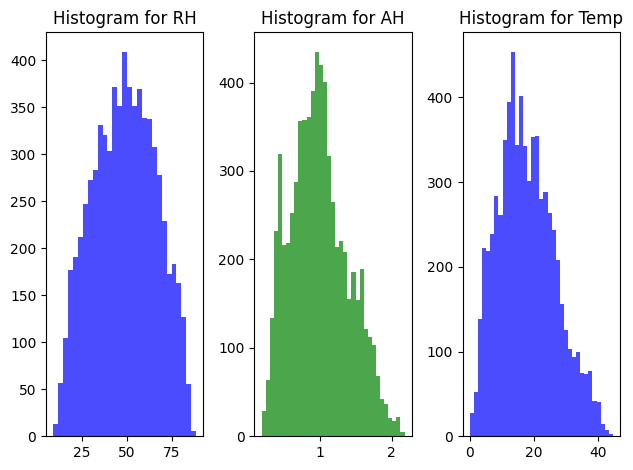

In [14]:
plt.subplot(1, 3, 1)
plt.hist(aqi['RH'], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram for RH')

plt.subplot(1, 3, 2)
plt.hist(aqi['AH'], bins='auto', color='green', alpha=0.7)
plt.title('Histogram for AH')

plt.subplot(1, 3, 3)
plt.hist(aqi['T'], bins='auto', color='blue', alpha=0.7)
plt.title('Histogram for Temp')

plt.tight_layout()
plt.show()

In [15]:
z_scores_all = zscore(aqi[['T', 'RH', 'AH']])

# Identify outliers based on a threshold of 3 standard deviations
outliers_all = aqi[(abs(z_scores_all) > 3).any(axis=1)]
outliers_all

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
3213,2.10,1158.00,14.30,1126.00,153.00,693.00,143.00,1654.00,1150.00,44.30,13.00,1.18
3214,2.30,1186.00,15.10,1151.00,166.00,680.00,157.00,1686.00,1235.00,44.60,12.60,1.17


In [16]:
aqi.drop(index=[3213, 3214])

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.60,1360.00,11.90,1046.00,166.00,1056.00,113.00,1692.00,1268.00,13.60,48.90,0.76
1,2.00,1292.00,9.40,955.00,103.00,1174.00,92.00,1559.00,972.00,13.30,47.70,0.73
2,2.20,1402.00,9.00,939.00,131.00,1140.00,114.00,1555.00,1074.00,11.90,54.00,0.75
3,2.20,1376.00,9.20,948.00,172.00,1092.00,122.00,1584.00,1203.00,11.00,60.00,0.79
4,1.60,1272.00,6.50,836.00,131.00,1205.00,116.00,1490.00,1110.00,11.20,59.60,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.10,1314.00,13.50,1101.00,472.00,539.00,190.00,1374.00,1729.00,21.90,29.30,0.76
9353,2.40,1163.00,11.40,1027.00,353.00,604.00,179.00,1264.00,1269.00,24.30,23.70,0.71
9354,2.40,1142.00,12.40,1063.00,293.00,603.00,175.00,1241.00,1092.00,26.90,18.30,0.64
9355,2.10,1003.00,9.50,961.00,235.00,702.00,156.00,1041.00,770.00,28.30,13.50,0.51


In [17]:
aqi.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6930.00,6930.00,6930.00,6930.00,6930.00,6930.00,6930.00,6930.00,6930.00,6930.00,6930.00,6930.00
mean,2.18,1120.34,10.57,959.08,250.80,816.23,113.91,1453.78,1058.45,17.78,48.89,0.99
std,1.44,218.58,7.46,263.76,208.66,251.10,47.46,352.37,406.16,8.82,17.44,0.40
min,0.10,647.00,0.20,397.00,2.00,322.00,2.00,601.00,252.00,0.00,9.20,0.18
25%,1.10,958.00,4.90,760.00,103.00,642.00,79.00,1208.00,760.00,11.20,35.30,0.69
50%,1.90,1085.00,8.80,931.00,186.00,785.00,110.00,1458.00,1007.00,16.90,49.20,0.95
75%,2.90,1254.00,14.60,1136.00,334.75,945.75,142.00,1683.00,1323.00,23.70,62.20,1.25
max,11.90,2040.00,63.70,2214.00,1479.00,2683.00,333.00,2775.00,2523.00,44.60,88.70,2.18


### Checking for duplicate rows

In [18]:
# Select columns except the last two
columns_to_check = aqi.iloc[:, :-2]

# Check for duplicates in the selected columns
duplicates = columns_to_check.duplicated()

# Display rows with duplicates
rows_with_duplicates = aqi[duplicates]
rows_with_duplicates


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


### Checking highly correlated features to the target

In [19]:
corr_mat = aqi.corr()

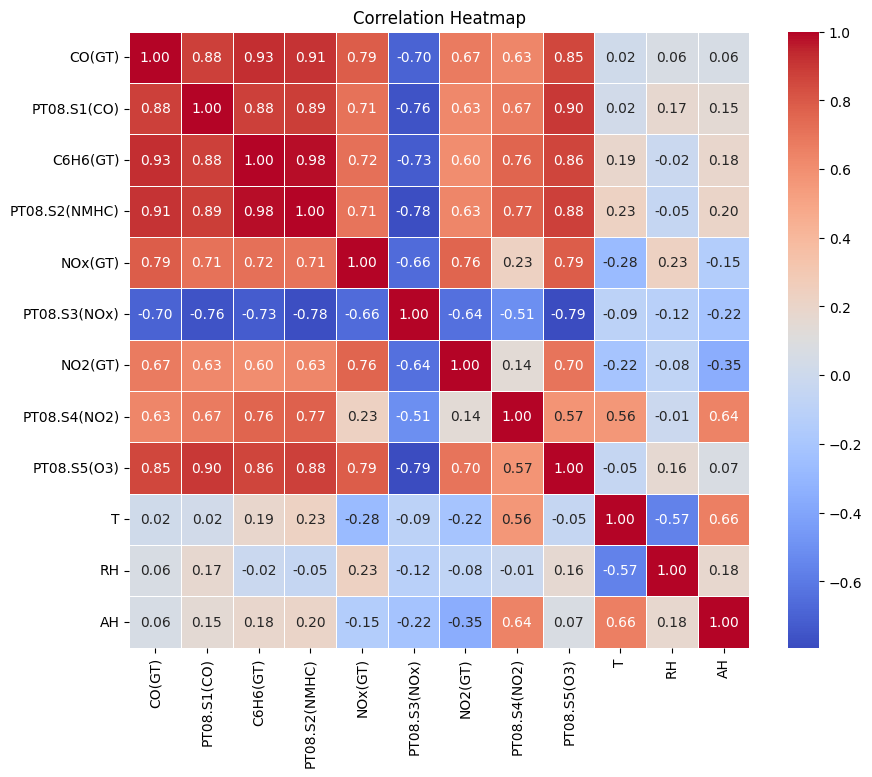

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

### Converting to test and train for multioutput regressor and scaling each column of y seperately

In [21]:
X = aqi.drop(['RH', 'AH', 'T'], axis=1)
y = aqi[['RH', 'AH', 'T']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = [StandardScaler() for _ in range(y.shape[1])]  # Create a scaler for each column in y

#Scaling X
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scaling individual Y
y_train_scaled = pd.DataFrame()
for i, col in enumerate(y_train.columns):
    y_train_scaled[col] = scaler_y[i].fit_transform(y_train[col].values.reshape(-1, 1)).flatten()

y_test_scaled = pd.DataFrame()
for i, col in enumerate(y_test.columns):
    y_test_scaled[col] = scaler_y[i].transform(y_test[col].values.reshape(-1, 1)).flatten()


### ML Algorithm With all features

In [22]:
tree_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
tree_regressor.fit(X_train_scaled, y_train_scaled)
tree_pred = tree_regressor.predict (X_test_scaled)

tree_mse = mean_squared_error(y_test_scaled, tree_pred, squared=False)
tree_r2 = r2_score(y_test_scaled, tree_pred)
print ('Tree_RMSE:', tree_mse)
print(f'Tree_R2: {tree_r2}')

Tree_RMSE: 0.6135822033516022
Tree_R2: 0.5984525141274215


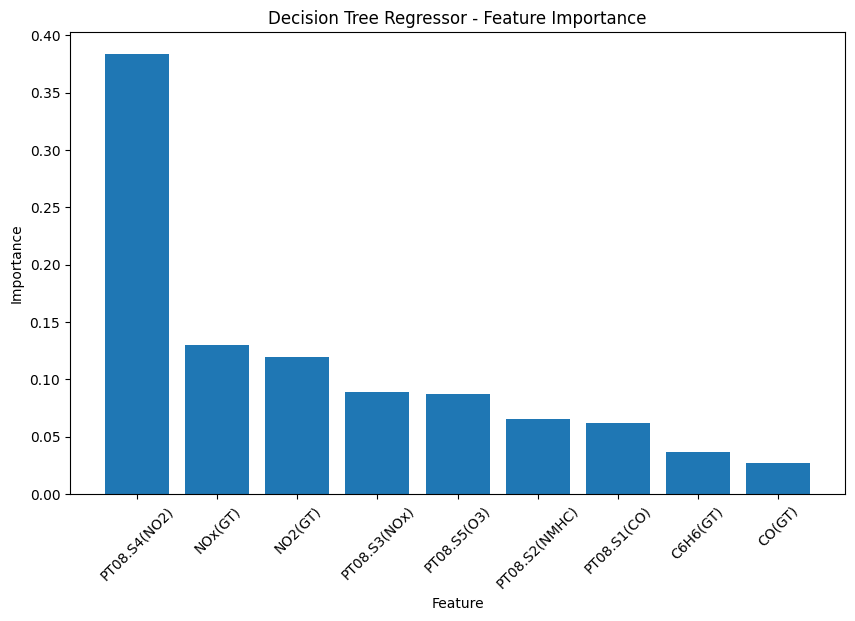

Selected Features with Importance > 0.1: ['PT08.S4(NO2)', 'NOx(GT)', 'NO2(GT)']


In [23]:
tree_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
tree_regressor.fit(X_train_scaled, y_train_scaled)

# Get feature importances
feature_importances = tree_regressor.feature_importances_

# Get the names of the features
feature_names = list(X_train.columns)  # Replace with your feature names

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Decision Tree Regressor - Feature Importance")
plt.show()

# Set your desired threshold
threshold = 0.1

# Filter features based on importance threshold
selected_features = [feature_names[i] for i in sorted_idx if feature_importances[i] > threshold]

# Print or use the selected features as needed
print("Selected Features with Importance > 0.1:", selected_features)


### Selecting features with feature importance more than 0.05

In [24]:
selected_columns = [feature_names[i] for i in sorted_idx if feature_importances[i] > 0.05]

X = aqi[selected_columns]
y = aqi[['RH', 'AH', 'T']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = [StandardScaler() for _ in range(y.shape[1])]  # Create a scaler for each column in y

#Scaling X
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scaling individual Y
y_train_scaled = pd.DataFrame()
for i, col in enumerate(y_train.columns):
    y_train_scaled[col] = scaler_y[i].fit_transform(y_train[col].values.reshape(-1, 1)).flatten()

y_test_scaled = pd.DataFrame()
for i, col in enumerate(y_test.columns):
    y_test_scaled[col] = scaler_y[i].transform(y_test[col].values.reshape(-1, 1)).flatten()

### With best features

In [25]:
tree_regressor = DecisionTreeRegressor(random_state=42)

tree_regressor.fit(X_train_scaled, y_train_scaled)
tree_pred = tree_regressor.predict (X_test_scaled)

tree_mse = mean_squared_error(y_test_scaled, tree_pred, squared=False)
tree_r2 = r2_score(y_test_scaled, tree_pred)
print ('Tree_RMSE:', tree_mse)
print(f'Tree_R2: {tree_r2}')

Tree_RMSE: 0.6188641002241343
Tree_R2: 0.5915132926318653


### Using LazyRegressor to test for best models

In [26]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

print(models)

  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.


 14%|█▍        | 6/42 [00:00<00:02, 14.57it/s]

BayesianRidge model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
ElasticNetCV model failed to execute
For multi-task outputs, use MultiTaskElasticNetCV


 21%|██▏       | 9/42 [00:03<00:13,  2.43it/s]

GammaRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.


 36%|███▌      | 15/42 [00:18<00:37,  1.38s/it]

GradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
HistGradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
HuberRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.


 50%|█████     | 21/42 [00:22<00:18,  1.13it/s]

LarsCV model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
LassoCV model failed to execute
For multi-task outputs, use MultiTaskLassoCV


 60%|█████▉    | 25/42 [00:23<00:08,  2.05it/s]

LassoLarsCV model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
LassoLarsIC model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
LinearSVR model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.


 71%|███████▏  | 30/42 [00:34<00:14,  1.23s/it]

NuSVR model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
OrthogonalMatchingPursuitCV model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
PassiveAggressiveRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
PoissonRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
QuantileRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.


 90%|█████████ | 38/42 [00:40<00:03,  1.18it/s]

SGDRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
SVR model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
TweedieRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.


100%|██████████| 42/42 [00:41<00:00,  1.02it/s]

LGBMRegressor model failed to execute
y should be a 1d array, got an array of shape (5544, 3) instead.
                            Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                      
ExtraTreesRegressor                       0.83       0.83  0.40        2.47
MLPRegressor                              0.83       0.83  0.41       11.20
RandomForestRegressor                     0.82       0.82  0.42        5.05
XGBRegressor                              0.82       0.82  0.42        0.79
KNeighborsRegressor                       0.82       0.82  0.42        0.09
BaggingRegressor                          0.80       0.80  0.44        0.36
RidgeCV                                   0.63       0.63  0.60        0.04
KernelRidge                               0.63       0.63  0.60        4.39
Ridge                                     0.63       0.63  0.60        0.02
Lars                                      0.63       0.63  0.

#### Testing with one of the best features

In [27]:
from xgboost import XGBRegressor

In [28]:
xg_reg = XGBRegressor(random_state=42)
xg_reg.fit(X_train_scaled, y_train_scaled)
xg_pred = xg_reg.predict(X_test_scaled)

xg_mse = mean_squared_error(y_test_scaled, xg_pred, squared=False)
xg_r2 = r2_score(y_test_scaled, xg_pred)
print ('XGBoost_RMSE:', xg_mse)
print(f'XGBoost_R2: {xg_r2}')


XGBoost_RMSE: 0.40442220147111446
XGBoost_R2: 0.8184951871769881


#### using GridSearch for best parameters

In [29]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search.fit(X_train_scaled, y_train_scaled)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

y_pred = grid_search.predict(X_test_scaled)

mse = mean_squared_error(y_test_scaled, y_pred)
print(f'Mean Squared Error: {mse}')

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Mean Squared Error: 0.16889568851900574


In [30]:
xg_reg = XGBRegressor(random_state=42, learning_rate=0.1, max_depth=5, n_estimators=300)
xg_reg.fit(X_train_scaled, y_train_scaled)
xg_pred = xg_reg.predict(X_test_scaled)

xg_mse = mean_squared_error(y_test_scaled, xg_pred, squared=False)
xg_r2 = r2_score(y_test_scaled, xg_pred)
print ('XGBoost_RMSE:', xg_mse)
print(f'XGBoost_R2: {xg_r2}')


XGBoost_RMSE: 0.39545759853830503
XGBoost_R2: 0.8265533643480661


In [31]:
results_df = pd.DataFrame({
    'True RH': y_test['RH'].values,
    'Predicted RH': xg_pred[:, 0],
    'RH Error': xg_pred[:, 0]-y_test['RH'],
    'True AH': y_test['AH'].values,
    'Predicted AH': xg_pred[:, 1],
    'AH Error': xg_pred[:, 1]-y_test['AH'].values,
    'True T': y_test['T'].values,
    'Predicted T': xg_pred[:, 2],
    'T Error': xg_pred[:, 2]-y_test['T'].values,
})

In [32]:
results_df

,True RH,Predicted RH,RH Error,True AH,Predicted AH,AH Error,True T,Predicted T,T Error
4877,47.80,0.18,-47.62,1.13,0.27,-0.86,20.30,-0.11,-20.41
6632,57.80,0.13,-57.67,0.58,-0.95,-1.53,6.80,-0.88,-7.68
8769,50.10,0.46,-49.64,0.46,-1.45,-1.92,5.70,-1.60,-7.30
8669,46.30,-0.21,-46.51,0.44,-1.42,-1.86,6.10,-1.32,-7.42
7481,34.40,-0.18,-34.58,0.44,-1.46,-1.90,10.70,-1.31,-12.01
...,...,...,...,...,...,...,...,...,...
49,43.40,-0.78,-44.18,0.71,-0.56,-1.26,14.40,0.04,-14.36
4736,55.80,0.57,-55.23,1.48,0.86,-0.62,22.30,0.31,-21.99
2900,19.60,-1.65,-21.25,1.04,0.06,-0.98,34.20,1.83,-32.37
1278,49.30,-0.05,-49.35,1.01,0.25,-0.76,18.00,0.47,-17.53


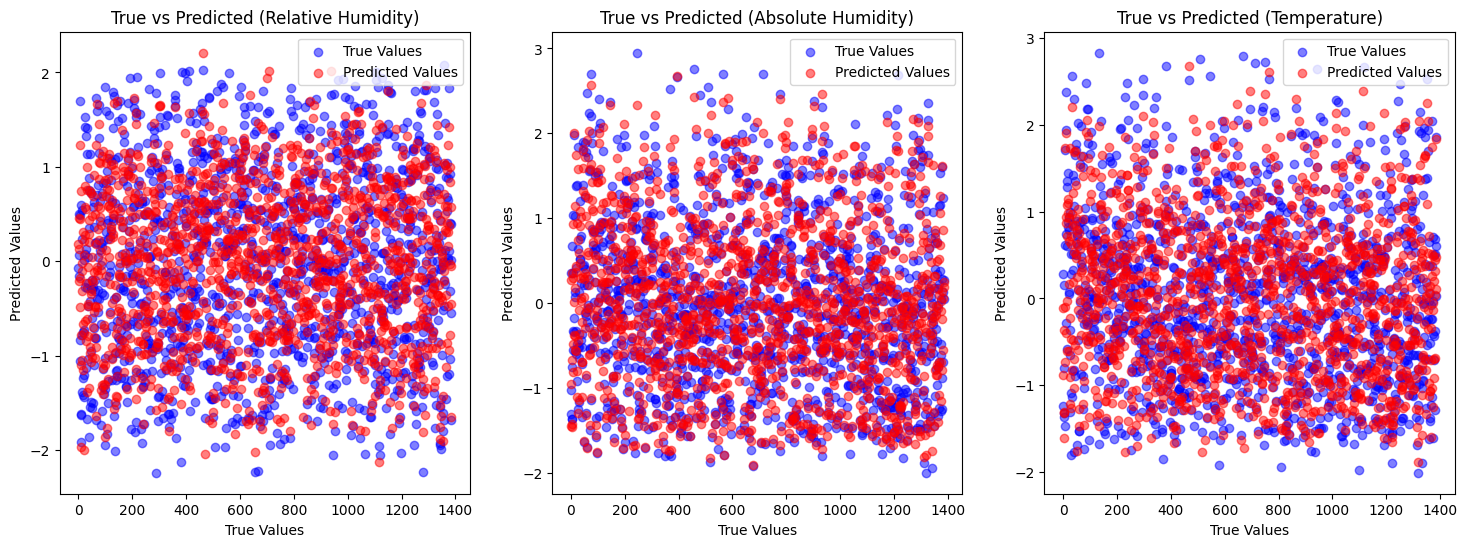

In [33]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(1386), y_test_scaled['RH'], color='blue', label='True Values', alpha=0.5)
plt.scatter(range(1386), xg_pred[:, 0], color='red', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted (Relative Humidity)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(1386), y_test_scaled['AH'], color='blue', label='True Values', alpha=0.5)
plt.scatter(range(1386), xg_pred[:, 1], color='red', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted (Absolute Humidity)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(1386), y_test_scaled['T'], color='blue', label='True Values', alpha=0.5)
plt.scatter(range(1386), xg_pred[:, 2], color='red', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted (Temperature)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()


In [34]:
base_model = LinearRegression()
multioutput_model = MultiOutputRegressor(base_model)
multioutput_model.fit(X_train_scaled, y_train)
lr_pred = multioutput_model.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test_scaled, lr_pred, squared=False)
lr_r2 = r2_score(y_test_scaled, lr_pred)
print(f"Mean Squared Error: {lr_mse}")
print(f"R2: {lr_r2}")

Mean Squared Error: 23.38316773147289
R2: -973.2861215912147


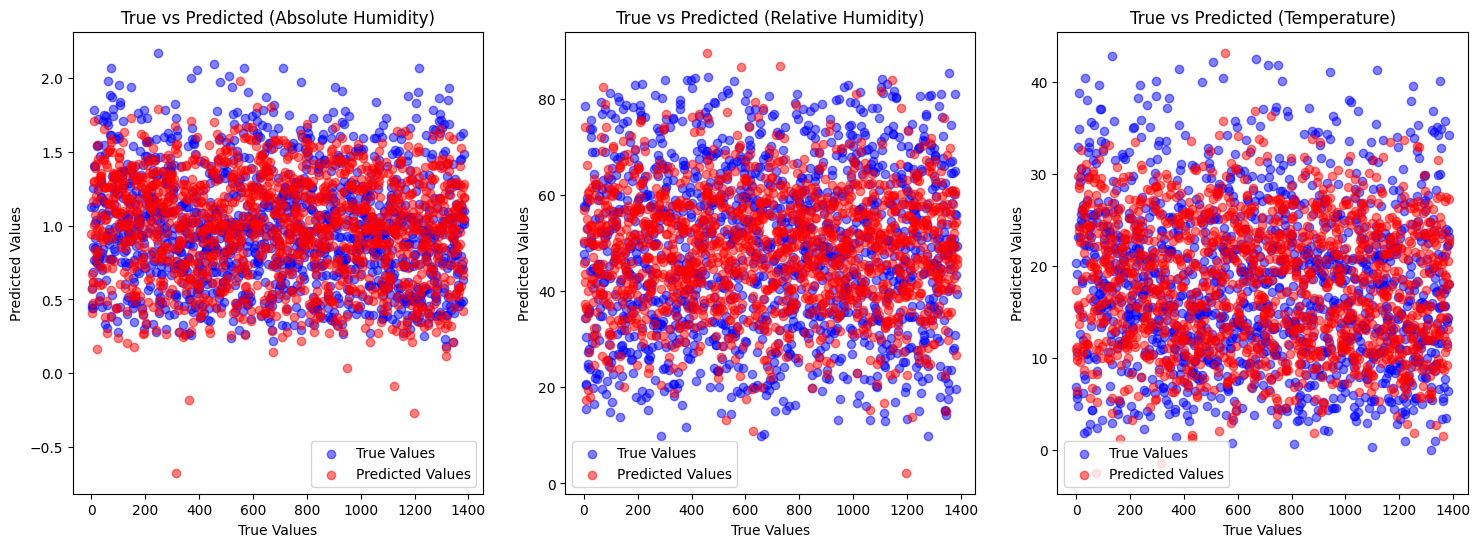

In [35]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(1386), y_test['RH'], color='blue', label='True Values', alpha=0.5)
plt.scatter(range(1386), lr_pred[:, 0], color='red', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted (Relative Humidity)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.subplot(1, 3, 1)
plt.scatter(range(1386), y_test['AH'], color='blue', label='True Values', alpha=0.5)
plt.scatter(range(1386), lr_pred[:, 1], color='red', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted (Absolute Humidity)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(1386), y_test['RH'], color='blue', label='True Values', alpha=0.5)
plt.scatter(range(1386), lr_pred[:, 0], color='red', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted (Relative Humidity)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(1386), y_test['T'], color='blue', label='True Values', alpha=0.5)
plt.scatter(range(1386), lr_pred[:, 2], color='red', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted (Temperature)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()



In [36]:
base_model = SVR()
svr_multioutput_model = MultiOutputRegressor(base_model)
svr_multioutput_model.fit(X_train_scaled, y_train_scaled)
svr_pred = svr_multioutput_model.predict(X_test_scaled)

svr_mse = mean_squared_error(y_test_scaled, svr_pred, squared=False)
svr_r2 = r2_score(y_test_scaled, svr_pred)
print(f"Mean Squared Error: {svr_mse}")
print(f"R2: {svr_r2}")

Mean Squared Error: 0.4181472827020159
R2: 0.8070309962541247


In [37]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train_scaled)
dt_pred = dt_model.predict(X_test_scaled)

dt_mse = mean_squared_error(y_test_scaled, dt_pred, squared=False)
dt_r2 = r2_score(y_test_scaled, dt_pred)
print(f"Mean Squared Error: {dt_mse}")
print(f"R2: {dt_r2}")

Mean Squared Error: 0.6188641002241343
R2: 0.5915132926318653


In [38]:
rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
rf_reg.fit(X_train_scaled, y_train_scaled)
rf_pred = rf_reg.predict(X_test_scaled)

rf_mse = mean_squared_error(y_test_scaled, rf_pred, squared=False)
rf_r2 = r2_score(y_test_scaled, rf_pred)
print ('RF_RMSE:', rf_mse)
print(f'RF_R2: {rf_r2}')


RF_RMSE: 0.44500220558206177
RF_R2: 0.7876044383994293
